#### RNN based on Steinmetz `spks` dataset and code from [nma](https://deeplearning.neuromatch.io/projects/Neuroscience/neuro_seq_to_seq.html)

##### Imports

In [1]:
# Imports
import torch
import random
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, io, models, ops, transforms, utils
from matplotlib import pyplot as plt

##### Device

In [2]:
def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("GPU is not enabled in this notebook. \n"
          "If you want to enable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `GPU` from the dropdown menu")
  else:
    print("GPU is enabled in this notebook. \n"
          "If you want to disable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `None` from the dropdown menu")

  return device

##### Set random seed

In [3]:
# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [4]:
SEED = 2021
set_seed(seed=SEED)
device = set_device()

Random seed 2021 has been set.
GPU is enabled in this notebook. 
If you want to disable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `None` from the dropdown menu


##### Data retrieval

In [5]:
# store the dataset files in the datasets folder
import os, requests

fname = []
ds = "../datasets"

for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile("/".join([ds, fname[j]])):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open("/".join([ds, fname[j]]), "wb") as fid:
          fid.write(r.content)

In [6]:
# data loading
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat,
                      np.load("/".join([ds, 'steinmetz_part%d.npz'%j]),
                              allow_pickle=True)['dat']))

##### Select recording 11

In [7]:
# select recording 11
dat = alldat[11]

##### Format dataset
An RNN has specific data requirements fed into the network for training, testing, and prediction. The depth of the network in a time or data series is given by `hidden_size`. In the case of the `spks` dataset this is 250 because one trial lasts for this many samples. These are the 250 sequenced datapoints related to the same mouse event trial from the same probe sensor size of 698 neurons over a time period of 2500ms. Further mouse trials are added in sequence in the dataset, where the training and forward algorithms reset to the start of the RNN. This dataset is then 698 neurons wide with 250 datapoints and 340 trials in length, before being split into train and test sets.

In [8]:
# data are neurons X trials x time samples, but permute to trials X time samples X neurons
x = torch.tensor(dat['spks']).permute(1,2,0)
x = x[:,50:150,:]

# response is -1, 0, 1, but convert to one hot where 2 takes the place of -1 to satisfy torch one hot
dat['response'][dat['response'] == -1] = 2 
y = torch.as_tensor(dat['response']).long()
y = F.one_hot(y)

# shuffle x and y together before split to ensure validation and test data are not chosen from the last trials


# split into train (70%), validation(20%) and test(10%) sets using batch size of 34
print(x.shape[0])
n_trials = int(x.shape[0])
ntr = int(n_trials * 7 / 10)
nv = int(n_trials * 2 / 10) + ntr

X_train = x[:ntr, :, :].to(device).float()
X_val = x[ntr:nv, :, :].to(device).float()
X_test = x[nv:, :, :].to(device).float()

y_train = y[:ntr].to(device).float()
y_val = y[ntr:nv].to(device).float()
y_test = y[nv:].to(device).float()

340


In [9]:
print(y[0])
print(x.shape)
print(y.shape)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

tensor([1, 0, 0])
torch.Size([340, 100, 698])
torch.Size([340, 3])
torch.Size([238, 100, 698])
torch.Size([238, 3])
torch.Size([68, 100, 698])
torch.Size([68, 3])
torch.Size([34, 100, 698])
torch.Size([34, 3])


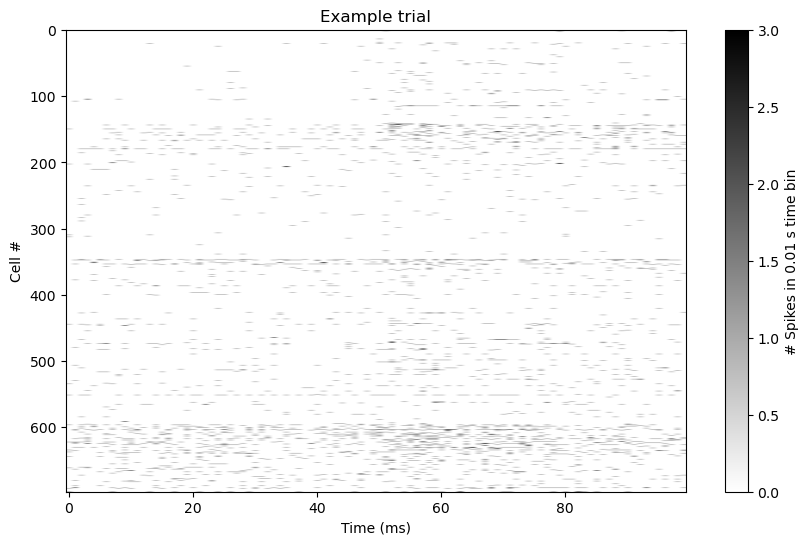

In [10]:
##### Visualise data from one trial
plt.figure(figsize = (10, 6))
plt.imshow(x[0,:,:].T, cmap='gray_r', vmax = 3, vmin=0, aspect='auto')
plt.xlabel('Time (ms)')
plt.ylabel('Cell #')
plt.colorbar(orientation='vertical', label='# Spikes in 0.01 s time bin')
plt.title('Example trial')
plt.show()

##### Dataloader

In [11]:
# batch_size of 34 used to match number of trials
batch_size = 34

# Create DataLoader for training data
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create DataLoader for validation data
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Create DataLoader for test data
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

##### Hyperparameters

In [12]:
# number of hidden RNN stages, inputs and outputs
hidden_size = x.shape[1]
input_size = x.shape[2]
output_size = y_train.shape[1]
num_layers = 1
learning_rate = 0.003
number_of_epochs = 10000

In [13]:
print(hidden_size)
print(input_size)
print(output_size)

100
698
3


##### Define RNN
Since the `hidden_size` is 250 we can expect to see either exploding or vanishing gradients in the RNN. For this case we can't expect the RNN to be able to predict well. But, as Dev did, we can reduce the `hidden_size` by slicing off data which doesn't correspond to wheel movement. 

In [14]:
# chatgpt 3.5 generated code
class NeuralRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(NeuralRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Define the RNN layer
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        
        # Define the fully connected layer to map RNN output to class labels
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate RNN
        out, _ = self.rnn(x, h0)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

##### Train the RNN: setup

In [15]:
model = NeuralRNN(input_size, hidden_size, output_size, num_layers).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#### Train the RNN

In [17]:
# Training loop
total_epochs = number_of_epochs

for epoch in range(total_epochs):
    model.train()
    total_loss = 0.0  

    for inputs, one_hot_labels in train_loader:
        inputs = inputs.to(device)
        one_hot_labels = one_hot_labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, one_hot_labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update the total loss for this epoch
        total_loss += loss.item()

    # Calculate average loss for this epoch
    average_train_loss = total_loss / len(train_loader)
    
    # Print the training loss for this epoch
    print(f'Epoch [{epoch+1}/{total_epochs}], Training Loss: {average_train_loss:.8f}')


    # Validation
    model.eval()
    total_val_loss = 0.0  
    
    with torch.no_grad():
        total_correct = 0
        total_samples = 0
        for inputs, one_hot_labels in val_loader:
            inputs = inputs.to(device)
            one_hot_labels = one_hot_labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, one_hot_labels)
            _, predicted = torch.max(outputs, 1)
            _, labels = torch.max(one_hot_labels, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            
            # Update the total validation loss for this epoch
            total_val_loss += loss.item() 
            
        # Calculate average validation loss for this epoch
        average_val_loss = total_val_loss / len(val_loader)

        accuracy = total_correct / total_samples
        print(f'Epoch [{epoch+1}/{total_epochs}], Validation Loss: {average_val_loss:.4f}, Validation Accuracy: {accuracy:.4f}')

# final training and validation losses
print(f'Final Training Loss: {average_train_loss:.8f}')
print(f'Final Validation Loss: {average_val_loss:.4f}')


Epoch [1/10000], Training Loss: 0.6769
Epoch [1/10000], Validation Loss: 0.8390, Validation Accuracy: 0.6324
Epoch [2/10000], Training Loss: 0.3855
Epoch [2/10000], Validation Loss: 0.8386, Validation Accuracy: 0.5294
Epoch [3/10000], Training Loss: 0.1346
Epoch [3/10000], Validation Loss: 0.9175, Validation Accuracy: 0.5294
Epoch [4/10000], Training Loss: 0.0388
Epoch [4/10000], Validation Loss: 0.8041, Validation Accuracy: 0.5735
Epoch [5/10000], Training Loss: 0.0144
Epoch [5/10000], Validation Loss: 0.9025, Validation Accuracy: 0.5735
Epoch [6/10000], Training Loss: 0.0052
Epoch [6/10000], Validation Loss: 1.0886, Validation Accuracy: 0.6029
Epoch [7/10000], Training Loss: 0.0027
Epoch [7/10000], Validation Loss: 1.1806, Validation Accuracy: 0.5588
Epoch [8/10000], Training Loss: 0.0017
Epoch [8/10000], Validation Loss: 1.1702, Validation Accuracy: 0.5588
Epoch [9/10000], Training Loss: 0.0012
Epoch [9/10000], Validation Loss: 1.1020, Validation Accuracy: 0.6176
Epoch [10/10000], T

##### Testing 

In [18]:
# Test the model
model.eval()
with torch.no_grad():
    total_correct = 0
    total_samples = 0
    for inputs, one_hot_labels in test_loader:
        inputs = inputs.to(device)
        one_hot_labels = one_hot_labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        _, labels = torch.max(one_hot_labels, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

    accuracy = total_correct / total_samples
    print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.5588
